# Grado en Ingeniería Informática
### **Asignatura**: Tratamiento de Señales Visuales/Tratamiento de Señales Multimedia I
### Práctica 4: Reconocimiento de escenas con Deep Learning

#### Pregunta 2

---

Autor: Rodrigo Juez Hernández (rodrigo.juezh@estudiante.uam.es), Universidad Autónoma de Madrid


# 0. Valores a probar en esta pregunta

In [ ]:
IMAGE_SIZES = [32, 64, 128, 224] # los tamaños de imagen siempre son 1:1 asi que no hace falta diferenciar entre width y height
BEST_BATCH_SIZE = 8 # numero de elementos procesados conjuntamente en cada iteracion
EPOCHS = 50 # numero de epocas para entrenamiento

# 1. Entorno
(Ejecuta una vez y compacta para que no moleste)

#### Entorno de trabajo
Instalación de librerías, comprobación de versiones, carga de dataset y elección de hardware.

In [ ]:
#%%capture
#%tensorflow_version 2.x
!pip install tensorflow==2.3.0
import tensorflow as tf
import numpy as np
import os, subprocess, pathlib, time
from google.colab import drive
import matplotlib.pyplot as plt

import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.optimizers as optimizers


     |████████████████████████████████| 320.4 MB 57 kB/s 
     |████████████████████████████████| 20.1 MB 12.7 MB/s 
     |████████████████████████████████| 2.9 MB 34.3 MB/s 
     |████████████████████████████████| 459 kB 45.8 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.7.0
    Uninstalling tensorflow-2.7.0:


In [ ]:
!python --version                     # mostrar version de python
print('Tensorflow ' + tf.__version__) # mostrar version tensorflow


# Montar Google Drive y crear carpetas
drive.mount('/content/gdrive', force_remount=True)

work_dir = '/content/work_dir'                    # directorio de trabajo en local (mas rapido)
dwld_dir = '/content/gdrive/My Drive/dwld_dir'    # directorio de descarga en Google drive personal
subprocess.call(["mkdir","-p",work_dir])          # crear directorio para trabajo
subprocess.call(["mkdir","-p",dwld_dir+'/dataset/'])  # crear directorio para dataset

os.chdir(dwld_dir+'/dataset/')                        # posicionarse en el directorio
# Descargar dataset scenes15 si no esta disponible
if os.path.isfile('./dataset_scenes15.zip') == False: 
  !wget http://www-vpu.eps.uam.es/~jcs/tsv/dataset_scenes15.zip 
  
# Copiar el dataset al directorio local (mayor velocidad de lectura que en Gdrive)
!cp /content/gdrive/My\ Drive/dwld_dir/dataset/dataset_scenes15.zip /content/work_dir/

os.chdir(work_dir)                        # posicionarse en el directorio
if os.path.isdir('./scenes15') == False: 
  !unzip -o -q dataset_scenes15.zip -d .

print('El dataset se encuentra descargado en el directorio {} \ny descomprimido en el directorio {} (usado para lectura de datos)'.format(dwld_dir, work_dir))

Python 3.7.12
Tensorflow 2.3.0
Mounted at /content/gdrive
El dataset se encuentra descargado en el directorio /content/gdrive/My Drive/dwld_dir 
y descomprimido en el directorio /content/work_dir (usado para lectura de datos)


In [ ]:
dataset_dir = pathlib.Path(work_dir + '/scenes15/')

# Obtener etiquetas de clase y numero de clases
CLASS_NAMES = np.array([item.name for item in dataset_dir.glob('*')]) #clases son subdirectorios de '/train/'
NUM_CLASSES = len(CLASS_NAMES) # numero total de clases

# 2. Preparación pregunta
Funciones para que instancian el generador, y el modelo para llamarlas reiteradamente.

#### Preparar dataset

In [ ]:
def generator_dataset(BATCH_SIZE = 16, IMG_HEIGHT = 32, IMG_WIDTH = 32, IMG_CHANNELS = 3):  
  # Crear ImageDataGenerator convirtiendo de uint8 a float32 en el rango [0,1].
  img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.20)

  # Obtenemos un iterador sobre los datos de entrenamiento del dataset
  # aplicando el ImageDataGenerator creado anteriormente

  train_data_gen = img_gen.flow_from_directory(directory=str(dataset_dir),
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            color_mode='rgb',                                                     
                                            classes = list(CLASS_NAMES),
                                            class_mode='categorical',
                                            batch_size=BATCH_SIZE, 
                                            subset="training",                                         
                                            shuffle=True,
                                            seed=0)

  test_data_gen = img_gen.flow_from_directory(directory=str(dataset_dir),
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            color_mode='rgb',                                                     
                                            classes = list(CLASS_NAMES),
                                            class_mode='categorical',
                                            batch_size=BATCH_SIZE,
                                            subset="validation",
                                            shuffle=True,
                                            seed=0)
  
  return train_data_gen, test_data_gen


#### Definir red y optimización

In [ ]:
def model_creation(IMG_HEIGHT = 32, IMG_WIDTH = 32, IMG_CHANNELS = 3, print_summary = False):  
  # definir modelo de red
  model = models.Sequential()

  # incluir capa convolucional C1
  model.add(layers.Conv2D(filters=6, 
                          kernel_size=(3, 3), 
                          strides = (1,1),
                          padding = 'valid',
                          activation='relu', 
                          input_shape=(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)))

  # incluir average pooling S2
  model.add(layers.AveragePooling2D())

  # incluir capa convolucional C3
  model.add(layers.Conv2D(filters=16, 
                          kernel_size=(3, 3),
                          strides = (1,1),
                          padding = 'valid', 
                          activation='relu'))

  # incluir average pooling S4
  model.add(layers.AveragePooling2D())

  # convertir el volumen de datos en vector fila para conectarlo con capa FC
  model.add(layers.Flatten())

  # incluir fully convolutional F5
  model.add(layers.Dense(units=120, activation='relu'))

  # incluir fully convolutional F6
  model.add(layers.Dense(units=84, activation='relu'))

  # incluir salida OUTPUT
  model.add(layers.Dense(units=NUM_CLASSES, activation = 'softmax'))


  # mostar resumen
  if print_summary == True:
    model.summary()


  # definicion con optimizador con valores definidos por el usuario
  LEARNING_RATE = 0.01 # factor de aprendizaje
  model.compile(optimizer=optimizers.SGD(lr=LEARNING_RATE),            
              loss='categorical_crossentropy',            
              metrics=['accuracy'])

  return model

# 3. Ejecución

In [ ]:
IMG_CHANNELS = 3

test_loss_list = []
test_acc_list = []

train_loss_list = []
train_acc_list = []

test_loss_list = []
test_acc_list = []

train_loss_list = []
train_acc_list = []

history_acc_list = []
history_val_acc_list = []
history_loss_list = []
history_val_loss_list = []

for image_size in IMAGE_SIZES:
  print(f"{'='*10} INICIANDO IMAGE_SIZE {image_size} {'='*10}")
  
  model = model_creation(IMG_HEIGHT = image_size, IMG_WIDTH = image_size, IMG_CHANNELS = IMG_CHANNELS, print_summary = False)
  train_data_gen, test_data_gen = generator_dataset(BATCH_SIZE = BEST_BATCH_SIZE, IMG_HEIGHT = image_size, IMG_WIDTH = image_size, IMG_CHANNELS = IMG_CHANNELS)

  with tf.device('/GPU:0'):
    history = model.fit_generator(
        generator=train_data_gen,          
        steps_per_epoch=train_data_gen.n // BEST_BATCH_SIZE,      
        validation_data=test_data_gen,
        validation_steps=test_data_gen.n // BEST_BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1     
    )


    
  
        
    test_loss, test_acc = model.evaluate_generator( generator=test_data_gen, 
                                                    steps = test_data_gen.n // BEST_BATCH_SIZE, 
                                                    verbose=1)

    train_loss, train_acc = model.evaluate_generator( generator=train_data_gen, 
                                                    steps = train_data_gen.n // BEST_BATCH_SIZE, 
                                                    verbose=1)

  
  test_loss_list.append(test_loss)
  test_acc_list.append(test_acc)

  train_loss_list.append(train_loss)
  train_acc_list.append(train_acc)

  history_acc_list.append(history.history['accuracy']         )
  history_val_acc_list.append(history.history['val_accuracy'] )

  # funcion de perdidas
  history_loss_list.append(history.history['loss']            )
  history_val_loss_list.append(history.history['val_loss']    )
  
  


print("test_loss_list: ", test_loss_list)
print("test_acc_list: ", test_acc_list)

print("train_loss_list: ", train_loss_list)
print("train_acc_list: ", train_acc_list)

========== INICIANDO IMAGE_SIZE 32 ==========
Found 3592 images belonging to 15 classes.
Found 893 images belonging to 15 classes.
Epoch 1/50
449/449 [==============================] - 6s 14ms/step - loss: 2.6974 - accuracy: 0.0919 - val_loss: 2.6838 - val_accuracy: 0.0856
Epoch 2/50
449/449 [==============================] - 6s 13ms/step - loss: 2.6611 - accuracy: 0.1024 - val_loss: 2.6384 - val_accuracy: 0.0957
Epoch 3/50
449/449 [==============================] - 6s 13ms/step - loss: 2.5800 - accuracy: 0.1425 - val_loss: 2.5876 - val_accuracy: 0.1329
Epoch 4/50
449/449 [==============================] - 6s 13ms/step - loss: 2.5081 - accuracy: 0.1701 - val_loss: 2.5466 - val_accuracy: 0.1757
Epoch 5/50
449/449 [==============================] - 6s 13ms/step - loss: 2.4362 - accuracy: 0.2032 - val_loss: 2.4873 - val_accuracy: 0.1903
Epoch 6/50
449/449 [==============================] - 6s 13ms/step - loss: 2.3698 - accuracy: 0.2210 - val_loss: 2.4699 - val_accuracy: 0.2005
Epoch 7/50


# 4. Plotting resultados

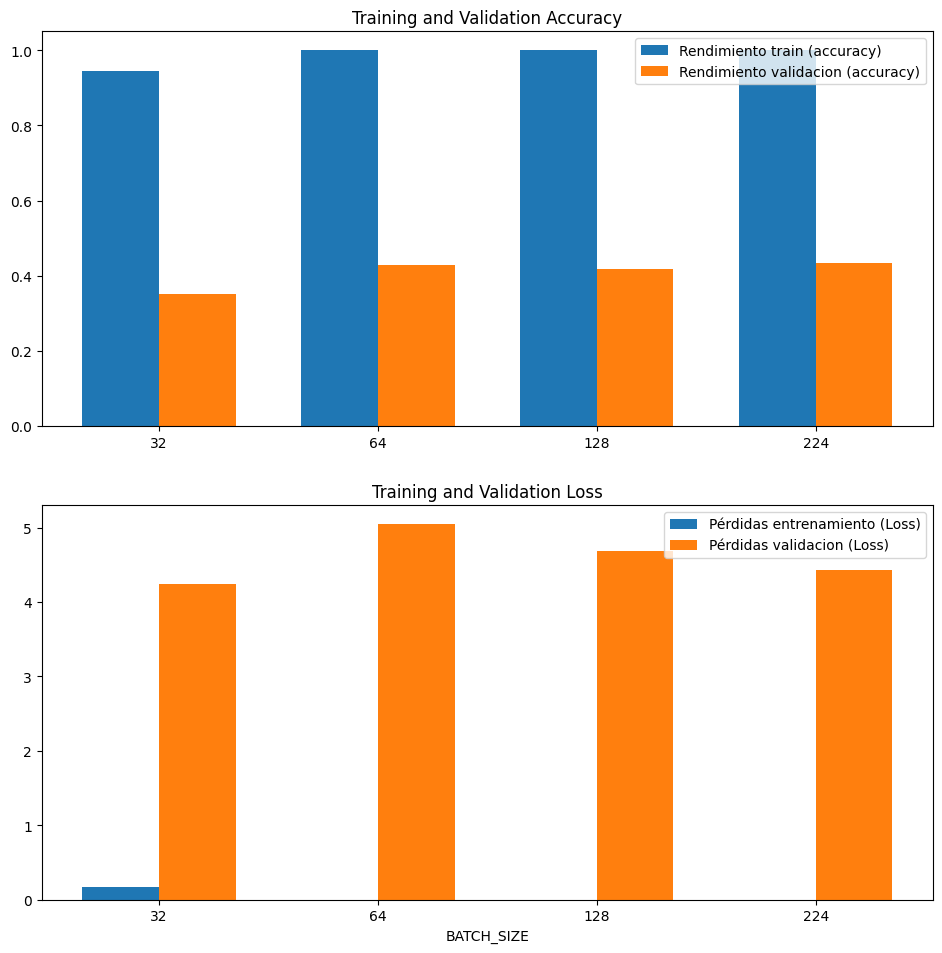

In [ ]:
"""
history_acc_list = []
history_val_acc_list = []
history_loss_list = []
history_val_loss_list = []
"""

ind = np.arange(len(IMAGE_SIZES))
width = 0.35 

fig, axs = plt.subplots(2,1)
axs[0].bar(ind, train_acc_list,width,  label='Rendimiento train (accuracy)')
axs[0].bar(ind + width, test_acc_list,width,  label='Rendimiento validacion (accuracy)')
axs[0].legend(loc='upper right')
axs[0].set_title('Training and Validation Accuracy')

axs[0].set_xticks(ind + width / 2)
axs[0].set_xticklabels(IMAGE_SIZES)




axs[1].bar(ind, train_loss_list,width,  label='Pérdidas entrenamiento (Loss)')
axs[1].bar(ind + width, test_loss_list,width,  label='Pérdidas validacion (Loss)')
axs[1].legend(loc='upper right')
axs[1].set_title('Training and Validation Loss')

axs[1].set_xticks(ind + width / 2)
axs[1].set_xticklabels(IMAGE_SIZES)
axs[1].set_xlabel('BATCH_SIZE')


fig.set_size_inches(11.5, 11.5)
fig.set_dpi(100)
plt.show()

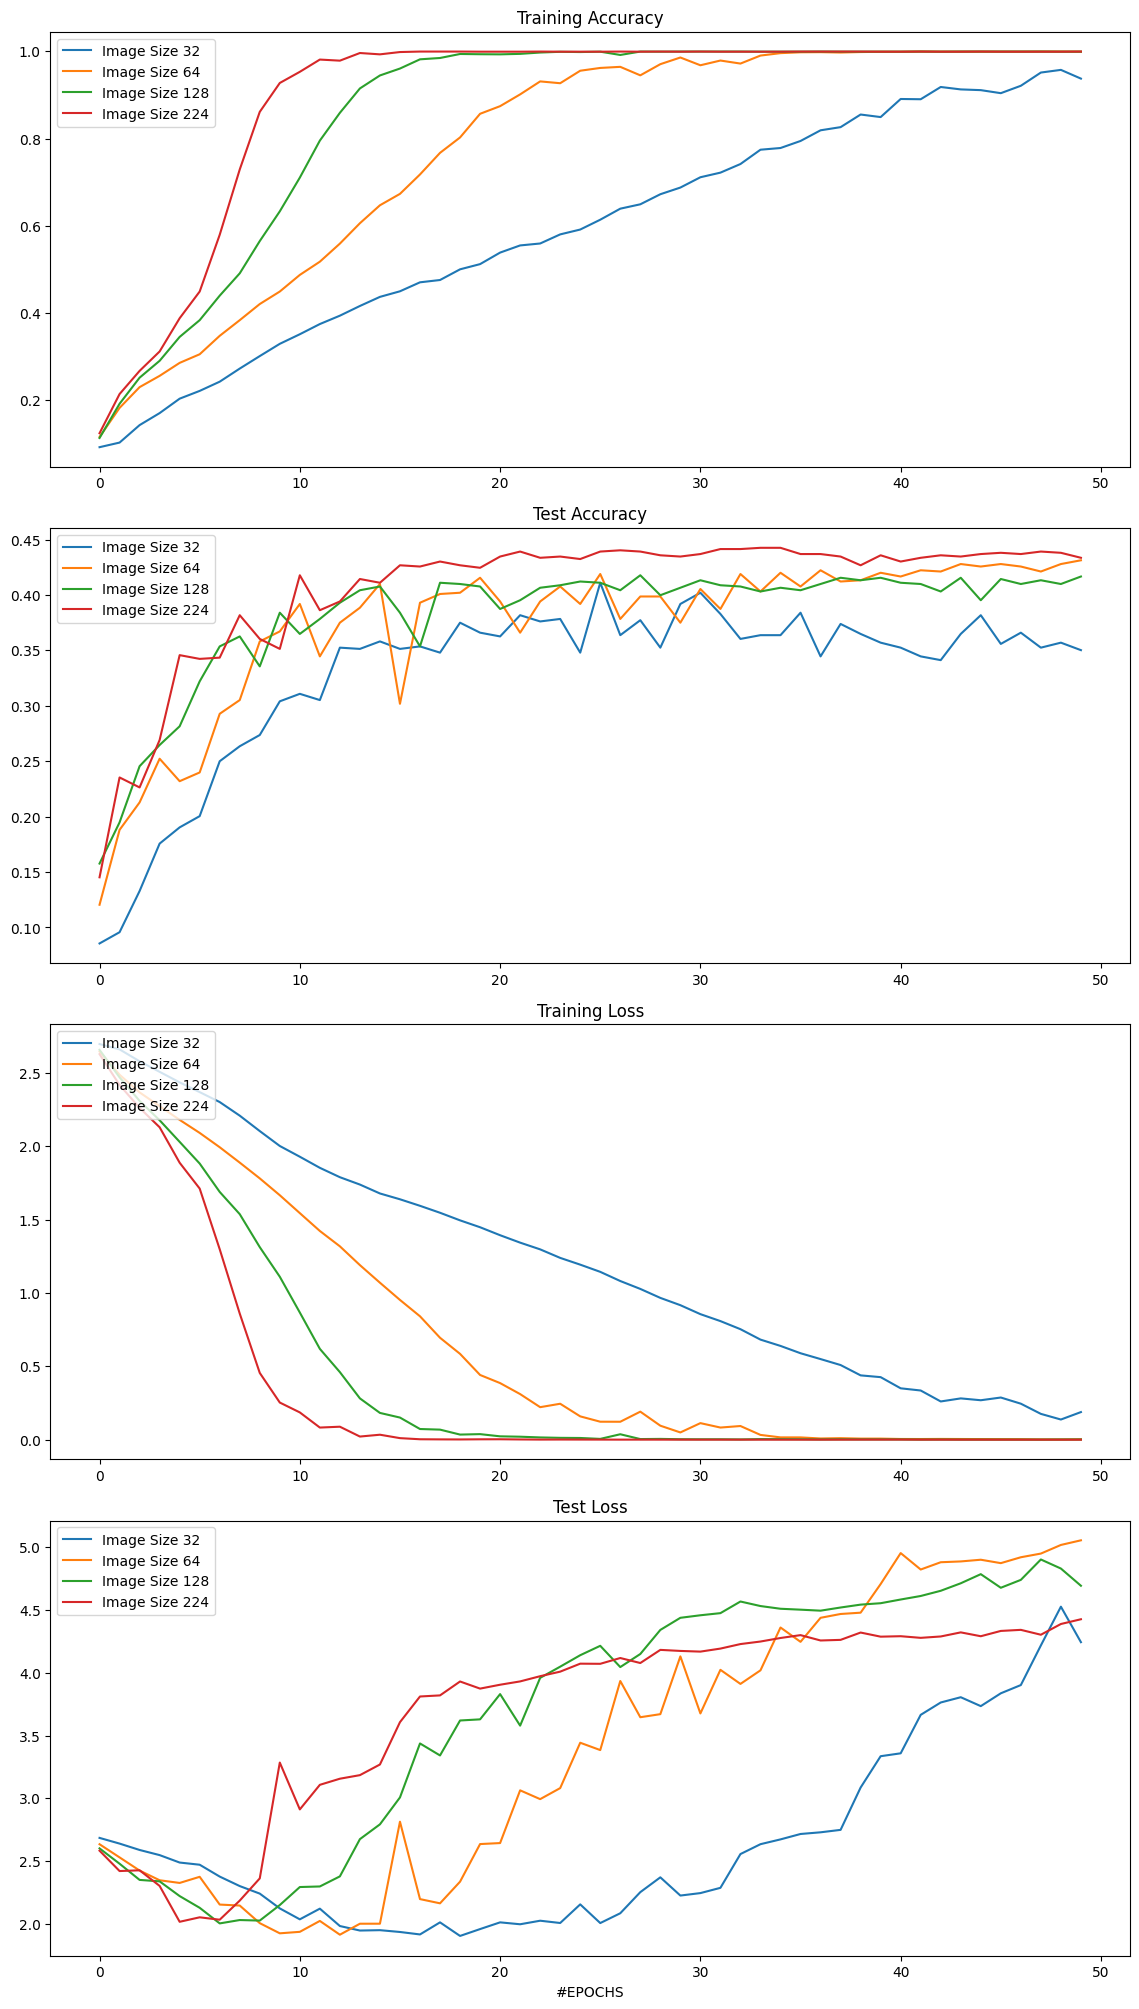

In [ ]:
"""test_loss_list = []
test_acc_list = []

train_loss_list = []
train_acc_list = []

history_acc_list = []
history_val_acc_list = []
history_loss_list = []
history_val_loss_list = []
"""

fig, axs = plt.subplots(4,1)
epoch_list = np.arange(EPOCHS)

for idx, batch_size in enumerate(IMAGE_SIZES):
  axs[0].plot(epoch_list, history_acc_list[idx],  label=f'Image Size {batch_size}')
  axs[0].set_title(f'Training Accuracy')
  axs[0].legend(loc='upper left')

for idx, batch_size in enumerate(IMAGE_SIZES):
  axs[1].plot(epoch_list, history_val_acc_list[idx],  label=f'Image Size {batch_size}')
  axs[1].set_title(f'Test Accuracy')
  axs[1].legend(loc='upper left')


for idx, batch_size in enumerate(IMAGE_SIZES):
  axs[2].plot(epoch_list, history_loss_list[idx],  label=f'Image Size {batch_size}')
  axs[2].set_title(f'Training Loss')
  axs[2].legend(loc='upper left')


for idx, batch_size in enumerate(IMAGE_SIZES):
  axs[3].plot(epoch_list, history_val_loss_list[idx],  label=f'Image Size {batch_size}')
  axs[3].set_title(f'Test Loss')
  axs[3].legend(loc='upper left')


  
  

fig.set_size_inches(11.5, 20)
fig.set_dpi(100)
plt.tight_layout()
plt.xlabel("#EPOCHS")
plt.show()

In [ ]:
print("test_loss_list: ", test_loss_list)
print("test_acc_list: ", test_acc_list)

print("train_loss_list: ", train_loss_list)
print("train_acc_list: ", train_acc_list)

print("history_acc_list: ", history_acc_list)
print("history_val_acc_list: ", history_val_acc_list)
print("history_loss_list: ", history_loss_list)
print("history_val_loss_list: ", history_val_loss_list)

test_loss_list:  [4.239233493804932, 5.050307273864746, 4.688470363616943, 4.427689552307129]
test_acc_list:  [0.3502252399921417, 0.42905405163764954, 0.41779279708862305, 0.434684693813324]
train_loss_list:  [0.16540972888469696, 0.002122162375599146, 0.0007301848381757736, 0.0005100982962176204]
train_acc_list:  [0.9443207383155823, 0.9997215867042542, 0.9997215867042542, 0.9997215867042542]
history_acc_list:  [[0.09187082201242447, 0.10244988650083542, 0.14253897964954376, 0.17010022699832916, 0.2032293975353241, 0.22104677557945251, 0.24220490455627441, 0.2722717225551605, 0.30094653367996216, 0.32906457781791687, 0.35105791687965393, 0.3744432032108307, 0.3936525583267212, 0.4159242808818817, 0.43680399656295776, 0.44961023330688477, 0.47021159529685974, 0.4755011200904846, 0.5, 0.5119710564613342, 0.538418710231781, 0.554844081401825, 0.5592984557151794, 0.5801782011985779, 0.5913140177726746, 0.6138641238212585, 0.6391982436180115, 0.6492204666137695, 0.6723273992538452, 0.6876